## Notes
There are a couple things i haven't taken a look into/(dont completely understand yet), this includes 
- ~~Extent array~~
- Padding factor

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm


In [2]:
# Import local modules
from modules.grid import create_spatial_grid, create_frequency_grid
from modules.field_generation import (
    generate_speckle_field,
    generate_reference_field,
)
from modules.holography import (
    create_hologram,
    compute_fourier_transform,
    create_filter_mask,
    apply_filter,
    shift_filtered_spectrum,
    reconstruct_field,
    
)



from modules.visualisation import (
    plot_complex_field,
    plot_fourier_spectrum,
    plot_filtered_spectrum,
    plot_reconstruction_comparison
)

# Import configuration
import config

# Mathematical Foundations of Off-Axis Holography

## References : 
- https://www.institut-langevin.espci.fr/biblio/2020/3/5/744/files/2011_off-axis_digital_hologram_reconstruction_some_practical_considerations.pdf
- https://qiweb.tudelft.nl/aoi/holography/holography.html
- -https://opg-optica-org.accesdistant.sorbonne-universite.fr/ao/fulltext.cfm?uri=ao-39-23-4070&id=62321
- https://github.com/wavefrontshaping/WFS.net/blob/master/off_axis_holography.ipynb



## 1. Field Definitions

### 1.1 Signal Field

The signal (or object) field $O(x,y)$ can be represented as a complex field:

$$O(x,y) = a_O(x,y)e^{i\phi_O(x,y)}$$

where $a_O(x,y)$ is the amplitude and $\phi_O(x,y)$ is the phase distribution.

In this simulation, we generate a spatially correlated random complex field by filtering white noise:

$$O(x,y) = \mathcal{G}_{\sigma}\{n_r(x,y)\} + i\mathcal{G}_{\sigma}\{n_i(x,y)\}$$

where:
- $n_r(x,y), n_i(x,y) \sim \mathcal{U}(-0.5, 0.5)$ are uniform random distributions
- $\mathcal{G}_{\sigma}\{\cdot\}$ is a Gaussian filter with standard deviation $\sigma = \text{grain\_size}/2$
- The resulting field is normalized: $O(x,y) \rightarrow \frac{O(x,y)}{|O(x,y)|}$

The parameter $\text{grain\_size}$ controls the characteristic size of features in the sample. 

### 1.2 Reference Field

The reference field $R(x,y)$ is a plane wave with a tilt angle, expressed as:

$$R(x,y) = a_R e^{i\vec{k}\cdot\vec{r}} = a_R e^{i(k_x x + k_y y)}$$

where:
- $a_R$ is the amplitude (typically normalized to 1)
- $\vec{k} = (k_x, k_y)$ is the wave vector that determines the tilt angle
- $\vec{r} = (x, y)$ is the position vector

In physical terms, the wavevector is related to the angle of incidence $\theta$ by:

$$k_x = \frac{2\pi}{\lambda}\sin\theta_x$$
$$k_y = \frac{2\pi}{\lambda}\sin\theta_y$$

where $\lambda$ is the wavelength and $\theta_x, \theta_y$ are the tilt angles in the $x$ and $y$ directions, respectively.

## 2. Hologram Formation

The hologram $H(x,y)$ is formed by the interference of the signal and reference fields, recorded as intensity:

$$H(x,y) = |O(x,y) + R(x,y)|^2$$

Expanding this expression:

$$H(x,y) = |O(x,y)|^2 + |R(x,y)|^2 + O(x,y)R^*(x,y) + O^*(x,y)R(x,y)$$

Which gives:

$$H(x,y) = |O(x,y)|^2 + |R(x,y)|^2 + a_O(x,y)a_R e^{i[\phi_O(x,y) - \vec{k}\cdot\vec{r}]} + a_O(x,y)a_R e^{-i[\phi_O(x,y) - \vec{k}\cdot\vec{r}]}$$

The four terms represent:
1. $|O(x,y)|^2$ - Zero-order term
2. $|R(x,y)|^2$ - Zero-order term
3. $O(x,y)R^*(x,y)$ - Virtual image term ($\pm 1$ order)
4. $O^*(x,y)R(x,y)$ - Real image term ($\mp 1$ order)

## 3. Fourier Analysis of the Hologram

The Fourier transform of the hologram $\mathcal{F}\{H(x,y)\} = \tilde{H}(f_x, f_y)$ separates these terms in the frequency domain:

$$\tilde{H}(f_x, f_y) = \mathcal{F}\{|O(x,y)|^2\} + \mathcal{F}\{|R(x,y)|^2\} + \mathcal{F}\{O(x,y)R^*(x,y)\} + \mathcal{F}\{O^*(x,y)R(x,y)\}$$

Using the convolution property of the Fourier transform:

$$\tilde{H}(f_x, f_y) = \tilde{I}_O(f_x, f_y) + \tilde{I}_R(f_x, f_y) + \tilde{O}(f_x, f_y) \otimes \delta(f_x+k_x/2\pi, f_y+k_y/2\pi) + \tilde{O}^*(-f_x, -f_y) \otimes \delta(f_x-k_x/2\pi, f_y-k_y/2\pi)$$



This shows that the FT of the hologram consists of:
1. The zero-order terms centered at $(0,0)$
2. There is a term centered at $(-k_x/2\pi, -k_y/2\pi)$ which corresponds to the $\pm 1$ term
3. There is a term centered at $(k_x/2\pi, k_y/2\pi)$ which corresponds to the $\mp 1$ term

## 4. Spatial Filtering and Reconstruction

### 4.1 Filtering

To isolate one of the image terms, we apply a bandpass filter $W(f_x, f_y)$ centered at one of the carrier frequencies:

$$\tilde{H}_f(f_x, f_y) = \tilde{H}(f_x, f_y) \cdot W(f_x + k_x/2\pi, f_y + k_y/2\pi)$$

The filter can be chosen to be a circular or rectangular window:

$$W(f_x, f_y) = 
\begin{cases} 
1 & \text{if } \sqrt{f_x^2 + f_y^2} < \Delta f \text{ (circular)} \\
1 & \text{if } |f_x| < \Delta f_x \text{ and } |f_y| < \Delta f_y \text{ (rectangular)} \\
0 & \text{otherwise}
\end{cases}$$

### 4.2 Carrier removal

We shift the filtered spectrum:

$$\tilde{H}_s(f_x, f_y) = \tilde{H}_f(f_x + k_x/2\pi, f_y + k_y/2\pi)$$

### 4.3 Reconstruction

The complex field is reconstructed by inverse Fourier transform:

$$\hat{O}(x,y) = \mathcal{F}^{-1}\{\tilde{H}_s(f_x, f_y)\}$$

The reconstructed phase is then:

$$\hat{\phi}_O(x,y) = \arg\{\hat{O}(x,y)\}$$




In [3]:
# Configuration parameters
Nx = 600
Ny = 400
grain_size = 20
kx = 500
padding_factor = 5


In [4]:
# Create spatial grid
X, Y, xv, yv = create_spatial_grid(Nx, Ny)


# Display grid dimensions
print(f"Grid dimensions: {Nx}x{Ny}")
print(f"X range: {X.min()} to {X.max()}")
print(f"Y range: {Y.min()} to {Y.max()}")

Grid dimensions: 600x400
X range: 0.0 to 1.0
Y range: 0.0 to 1.0


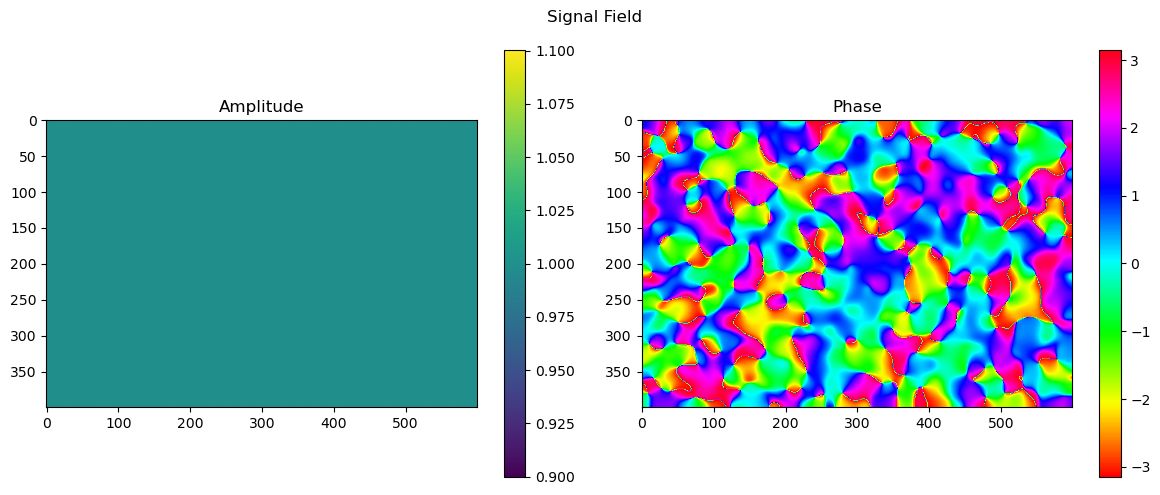

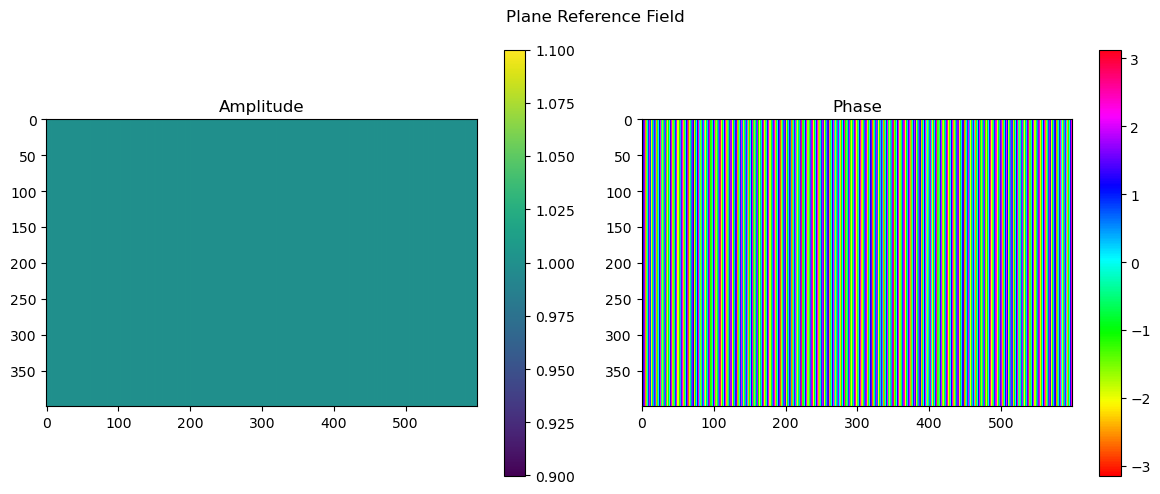

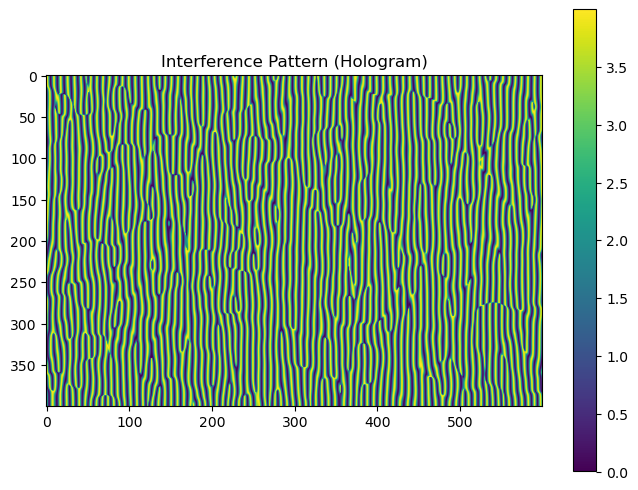

In [5]:
# Choose the signal type
signal_type = "speckle"  # Options: "speckle"

# Create signal field
signal_field = generate_speckle_field(Nx, Ny, grain_size, normalize= True)

# Plot the signal field
plot_complex_field(signal_field, title="Signal Field")

# Choose the reference type
ref_type = "plane"  # Options: "plane", "spherical", "gaussian"

# Generate reference field
reference_field = generate_reference_field(xv, yv, kx=kx, ref_type=ref_type)

# Plot the reference field
plot_complex_field(reference_field, title=f"{ref_type.capitalize()} Reference Field")

# Generate hologram
hologram = create_hologram(signal_field, reference_field)  # hologram = np.abs(signal_field + reference_field) ** 2

# Plots
plt.figure(figsize=(8, 6))
plt.imshow(hologram)
plt.title("Interference Pattern (Hologram)")
plt.colorbar()
plt.show()


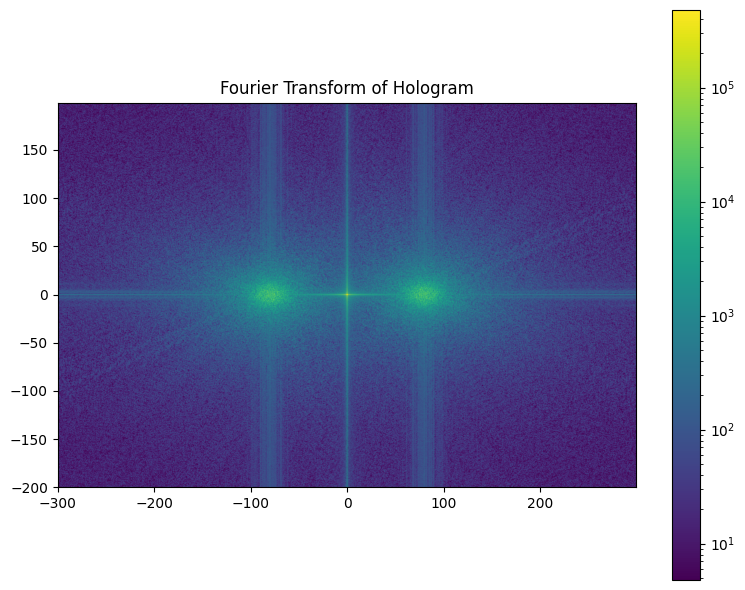

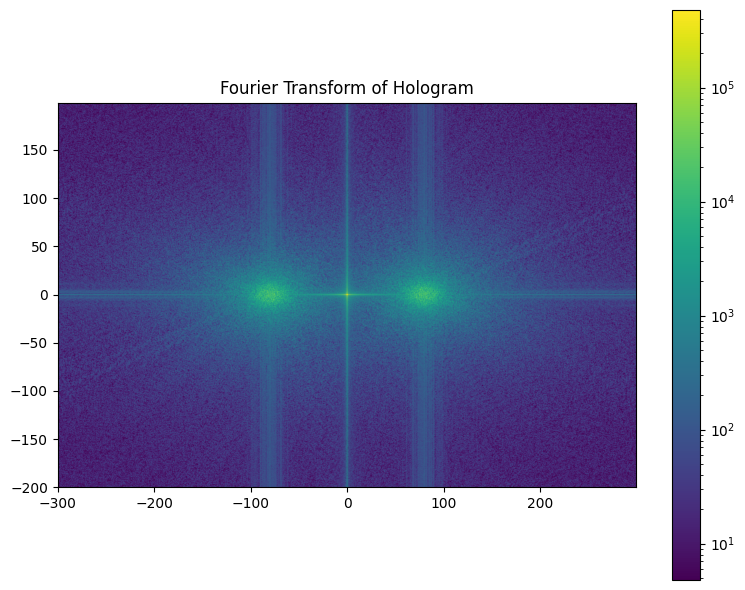

In [6]:
# Compute Fourier transform with padding
ft = compute_fourier_transform(hologram, padding_factor=padding_factor)

# Define extent for plotting
extent = [-0.5*Nx, 0.5*Nx-1, -0.5*Ny, 0.5*Ny-1] # extent = [left, right, bottom, top]

# Plot the Fourier spectrum
plot_fourier_spectrum(
    ft, 
    extent=extent, 
    title="Fourier Transform of Hologram"
)

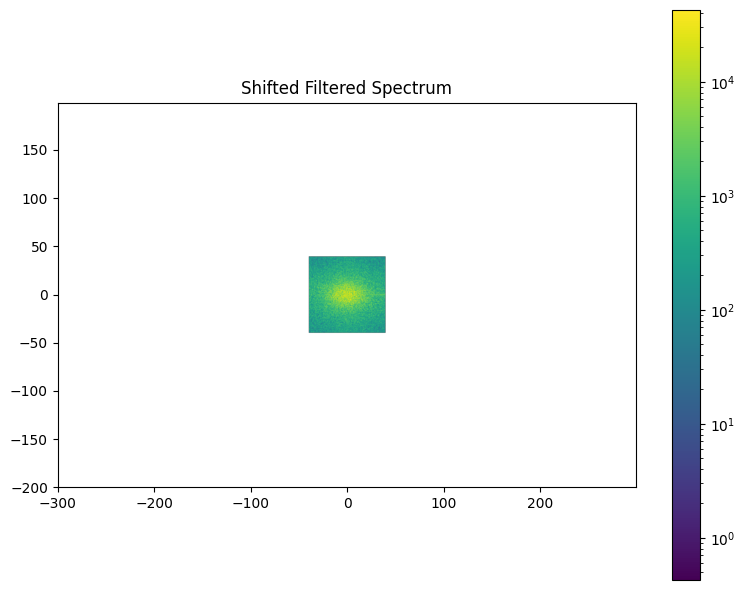

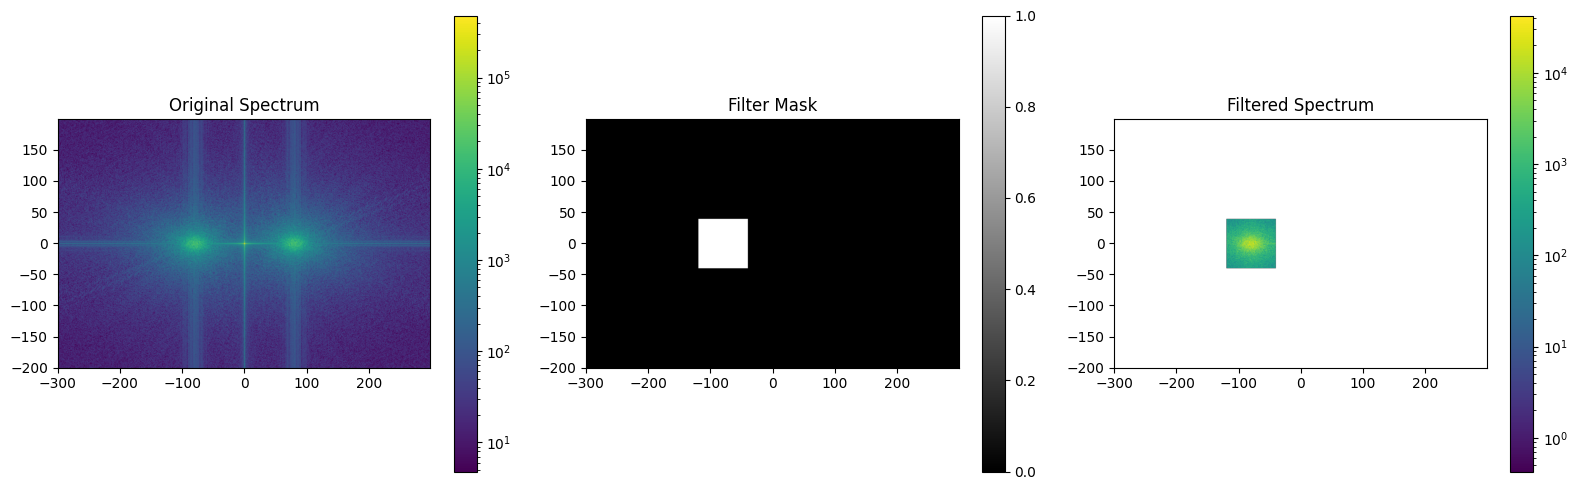

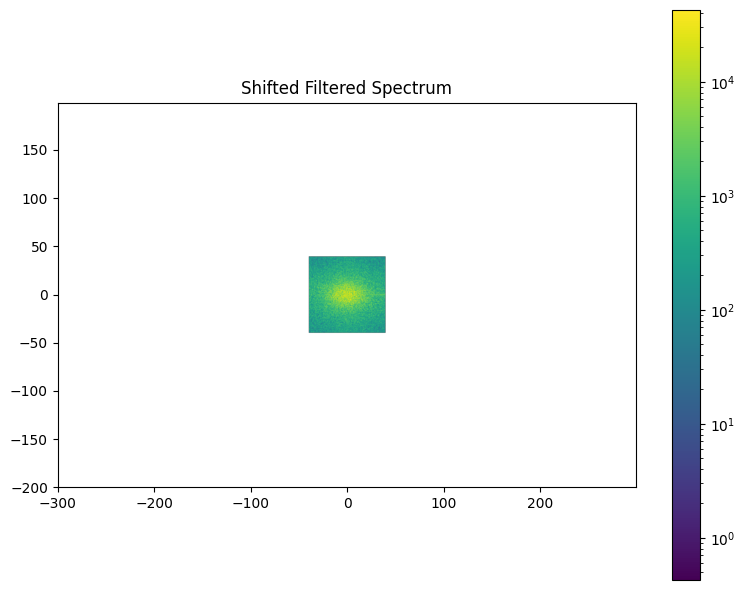

In [7]:
# Define filter parameters
freq = kx / (2 * np.pi)  # Central frequency of the filter
width = freq  # Width of the filter
filter_shape = "rect"  # Options: "rect", "circular"

# Create frequency grid
fx, fy, fxv, fyv = create_frequency_grid(Nx, Ny, padding_factor=padding_factor) # Same functions as create spatial grid

# Create filter mask
mask = create_filter_mask(fxv, fyv, (-freq, 0), width, shape=filter_shape)


# Apply filter
filtered_ft = apply_filter(ft, mask)

# Plot the filtering results
plot_filtered_spectrum(
    ft, 
    filtered_ft, 
    mask=mask, 
    extent=extent,
    figsize=(16, 5)
)


# Calculate shift vector based on carrier frequency
shift_vector = (np.round(freq * padding_factor), 0)

# Shift filtered spectrum
shifted_ft = shift_filtered_spectrum(filtered_ft, mask, shift_vector)

# Plot shifted spectrum
plot_fourier_spectrum(
    shifted_ft, 
    extent=extent, 
    title="Shifted Filtered Spectrum"
)

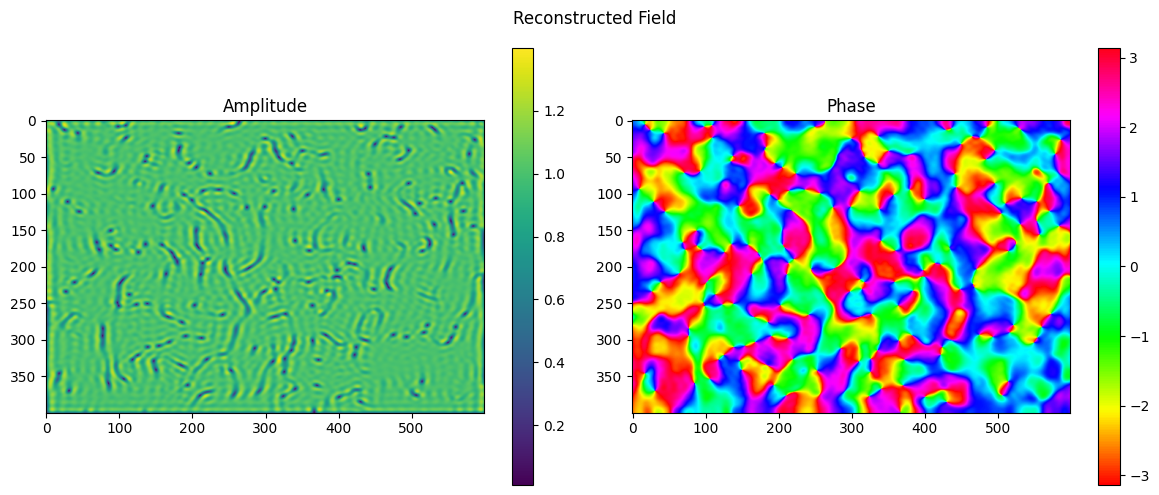

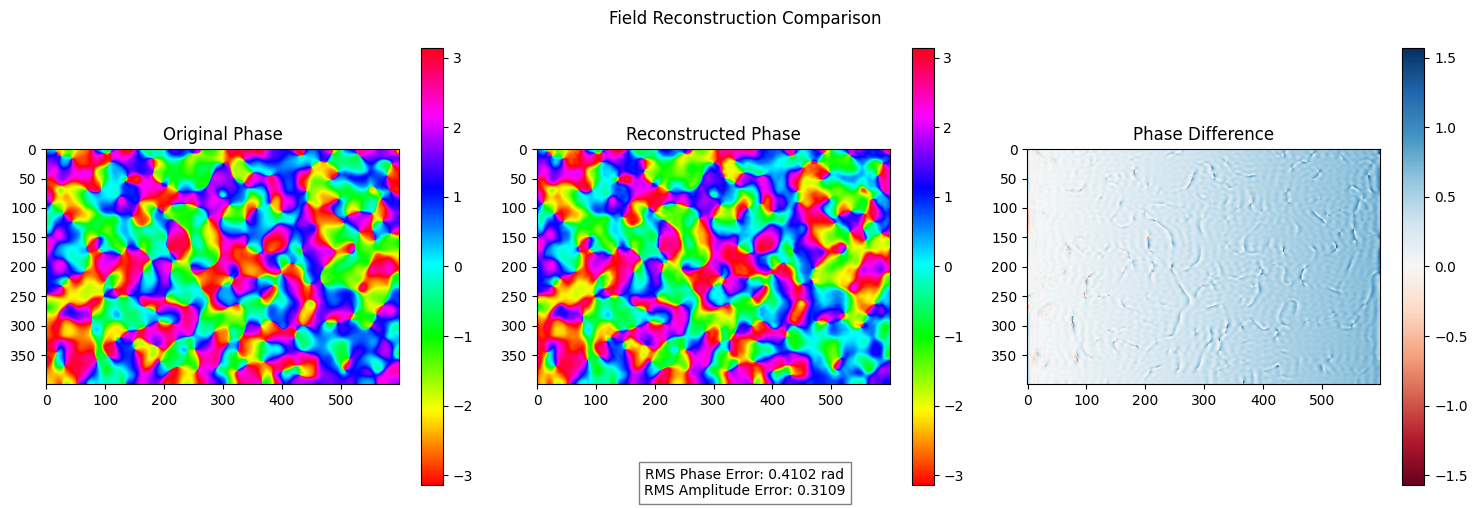

In [8]:
# Reconstruct field using Inverse Fourier Transform
reconstructed_field = reconstruct_field(shifted_ft, (Ny, Nx))

# Plot reconstructed field
plot_complex_field(reconstructed_field, title="Reconstructed Field")

# Compare original and reconstructed fields
fig, metrics = plot_reconstruction_comparison(
    
    signal_field,
    reconstructed_field,
    title="Field Reconstruction Comparison"
)

